In [1]:
%pylab inline
from math import atan2
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import multi_dot
import time
from functools import reduce
from matplotlib.widgets import Slider,Button
import os
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Used functions

#Matrix of a polarizator with theta angle in Jones matrix formalizm
def GLP(theta):
    return matrix([[cos(theta)**2,sin(theta)*cos(theta)],[sin(theta)*cos(theta),sin(theta)**2]])

#Matrix of a waveplate in Jones matric fomalizm
def GLR(retard,azang):
    Output=[]
    for r,a in zip(retard,azang): 
        A=exp(-1j*r*0.5)*cos(a)**2+exp(1j*r*0.5)*sin(a)**2
        B=-(-exp(-1j*0.5*r)+exp(1j*0.5*r))*cos(a)*sin(a)
        C=exp(1j*r*0.5)*cos(a)**2+exp(-1j*r*0.5)*sin(a)**2
        Output.append(matrix([[A,B],[B,C]]))
    return Output

def LamPlate(Angle,LightWaveLenght):
    r=2*pi*(0.532/LightWaveLenght)
    a=Angle
    A=exp(-1j*r*0.5)*cos(a)**2+exp(1j*r*0.5)*sin(a)**2
    B=2*1j*sin(a)*cos(a)*sin(r*0.5)
    C=exp(1j*r*0.5)*cos(a)**2+exp(-1j*r*0.5)*sin(a)**2
    return matrix([[A,B],[B,C]])

def DropHeight(x,y,contang,diameter):
    D=diameter**2/(4*sin(contang)**2)-x**2-y**2
    if D>0:
        H=sqrt(D)-0.5*(diameter/tan(contang))
        if H>0:
            return H
        else:
            return 0
    else:
        return 0
    
def DropHeightFromOrigin(x,y,contang,diameter):
    D=diameter**2/(4*sin(contang)**2)-x**2-y**2
    if D>0:
        return sqrt(D)
    else:
        return 0

def DirOnSurface(x,y,z):
    if z!=0:
        return atan2(y,x),atan2(z,sqrt(x**2+y**2))
    else:
        return 0,pi/2
    
def dirr2D(phi,theta):
    return [[cos(theta)*cos(phi)],[sin(theta)]]

def dirr2D_sc(phi,theta,scaler):
    out=array([[cos(theta)*cos(phi)*scaler],[sin(theta)]])
    s=sqrt(out[0]**2+out[1]**2)
    return out/s

def dirrxy2D(phi,theta):
    return [[cos(theta)*cos(phi)],[cos(theta)*sin(phi)]]

def dirr3D(phi,theta):
    return [[sin(theta)*cos(phi)],[sin(theta)*sin(phi)],[cos(theta)]]

def PlotDirecOnSurface(x,y,z,direc,zl=2):
    dirx=[i[0] for i in direc]
    diry=[i[1] for i in direc]
    dirz=[i[2] for i in direc]
    fig = figure()
    figsize=(20,20)
    LY=len(x)
    ax = fig.gca(projection='3d')
    for i in range(len(x)):
        for j in range(LY):
            ax.quiver(x[i], y[j], z[i*LY+j],dirx[i*LY+j],diry[i*LY+j],dirz[i*LY+j], length=0.1, normalize=True)
    ax.set_zlim(0,zl)
    show()
    
def HHCol(x,y,contang,diameter,zstep):
    h=DropHeight(x,y,contang,diameter)
    if h<=zstep:
        return array([0]),array([pi/2])
    else:
        steps=int(h/zstep)
        z=DropHeightFromOrigin(x,y,contang,diameter)
        phi,theta=DirOnSurface(x,y,z)
        ThetaArray=linspace(theta,pi/2,steps)
        #plot(ThetaArray/pi*180)
        #show()
        PhiArray=ones(steps)*phi
        return PhiArray,ThetaArray
    
    
    
def neff(theta,ne,no):
    u=(ne**2-no**2)/no**2
    return ne/(sqrt(1+u*sin(theta)**2))

def ret(lam,nef,no,thick):
    return (2*pi/lam)*(nef-no)*thick

def ColMul(MtxList):
    OutPut=matrix(eye(2))
    for M in MtxList:
        OutPut=OutPut*M
    return OutPut

def InDrop(x,y,d):
    if 2*sqrt(x**2+y**2)<=d:
        return True
    else:
        return False
    
def HomHomDrop(ContactAngle,Diameter,ExtReff,OrdReff,LightWaveLenght,XYRes,ZRes,WithLam=False):

    X,Y=linspace(-Diameter/2,Diameter/2,XYRes),linspace(-Diameter/2,Diameter/2,XYRes)
    Zstep = DropHeight(0,0,ContactAngle,Diameter)/ZRes
    Int=zeros((XYRes,XYRes))
    for i in range(XYRes):
        for j in range(XYRes):
            z=DropHeight(X[i],Y[j],ContactAngle,Diameter)
            step=int(z/Zstep)
            Phi,Theta=HHCol(X[i],Y[j],ContactAngle,Diameter,Zstep)
            R=ret(LightWaveLenght,neff(Theta,ExtReff,OrdReff),OrdReff,Zstep)
            G=GLR(R,Phi)
            G.append(matrix(eye(2)))
            if WithLam:
                Lam = LamPlate(pi/4,LightWaveLenght)
            else:
                Lam = matrix(eye(2))
            
            Sys=GLP(pi/2)*reduce(numpy.dot, G)*Lam *GLP(0)*matrix([[1],[0]])
            
            Int[i][j]=float(abs(Sys[0]*Sys[0].conj())+abs(Sys[1]*Sys[1].conj()))
    
    return Int


                
def mul(m1,m2): return m1*m2

def pipi(ang):
    if ang<(-pi/2): return ang+pi
    elif ang>pi/2: return ang-pi
    else: return ang
    
    
def inter(lower,upper,step):
    lower = pipi(lower)
    upper = pipi(upper)
    
    l=abs(lower-upper)
    if l<=pi/2:
        return linspace(upper,lower,step)
    else:
        l=pi-l
        direc=0
        if upper < lower: direc=1
            
        s=l/(step-1)*(-1)**direc
        out=[upper]
        new_ang=upper
        for i in range(step-1):
            new_ang=new_ang+s
            out.append(pipi(new_ang))
        return out     
def THsign(ang):
    if ang!=0:
        return sign(ang)
    else:
        return 1

def drop(ContactAngle,Diameter,ExtReff,OrdReff,LightWaveLenght,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,dense,ZNumDir,WithLam=False,
            DirrVisul=False,savename=None):
    #Direktortér vizuálása a z=0 síkban----------------------------------
    if DirrVisul:
        x,y=linspace(-Diameter/2,Diameter/2,20),linspace(-Diameter/2,Diameter/2,20)
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_ylim(-Diameter/2-5,Diameter/2+5)
        ax.set_xlim(-Diameter/2-5,Diameter/2+5)
        #ax.set_title("phi0="+str(phi_0))
        ax.set_xlabel("$\mu$m",fontsize=20)
        ax.set_ylabel("$\mu$m",fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        for i in range(len(x)):
            for j in range(len(y)):
                
                D=Diameter**2/(4*sin(ContactAngle)**2)-x[i]**2-y[j]**2
                if D > 0 and (sqrt(D)-0.5*(Diameter/tan(ContactAngle))) > 0 :
                    dropheight_fromorigin = sqrt(D)
                    phi=atan2(y[j],x[i])+(sqrt(x[i]**2+y[j]**2)-Diameter/2)*(-2/Diameter)*phi_0
                    #theta=THsign(theta_down)*(pi/2-atan2(sqrt(x[i]**2+y[j]**2),rcore_down)+2/pi*atan2(sqrt(x[i]**2+y[j]**2),rcore_down)*abs(theta_down))
                    theta=(atan2(dropheight_fromorigin,sqrt(x[i]**2+y[j]**2))-THsign(theta_up)*atan2(sqrt(x[i]**2+y[j]**2),rcore_up)+2/pi*atan2(sqrt(x[i]**2+y[j]**2),rcore_up)*(theta_up))
                    Dirr=dirrxy2D(phi,theta)
                    ax.quiver(x[i],y[j],Dirr[0],Dirr[1],scale_units="width",scale=10,angles='uv',headaxislength=0,headwidth=0,headlength=0,width=0.01,pivot="tail")
                    
        if savename !=None:
            try:
                os.makedirs(savename)
            except:
                print("Az adott fájl már létezik, válaszzon másikat.")
                return None
                    
            fig.savefig(savename+"/"+savename+"_phi_plot.png")
        show()
    #Direktortér vizuálása az x,y=0 síkban------------------------------- 
    if DirrVisul:
        xcord,sx,sz=linspace(-Diameter/2,Diameter/2,dense),[],[]
        fig , ax = subplots()
        ax.set_xlim(-(Diameter/2+5),Diameter/2+5)
        
        #ax.set_title("rcore_down="+str(rcore_down)+", theta_down="+str(round(theta_down,3))
        #            +"\nrcore_up="+str(rcore_up)+", theta_up="+str(round(theta_up,3)))
        ax.set_xlabel("$\mu$m",fontsize=40)
        ax.set_ylabel("$\mu$m",fontsize=40)
        ax.tick_params(axis='x', labelsize=40)
        ax.tick_params(axis='y', labelsize=40)
        thpl=[]
        thx=[]
        thup=[]
        for i in range(dense):
            x,y=xcord[i],0
            D=Diameter**2/(4*sin(ContactAngle)**2)-x**2-y**2
            Zmax= DropHeight(0,0,ContactAngle,Diameter)
            Zstep = Zmax/ZNumDir
            ax.set_ylim(-10,Zmax+10)
            scaler=(Diameter+5)/(Zmax+20)
            fig.set_figheight(5)
            fig.set_figwidth(5*scaler)
            sx.append(x)
            if D > 0 and (sqrt(D)-0.5*(Diameter/tan(ContactAngle))) > 0 :
                dropheight_fromorigin = sqrt(D)
                base=0.5*(Diameter/tan(ContactAngle))
                dropheight = dropheight_fromorigin-base
                step = int(dropheight/Zstep)
                sz.append(dropheight)
                if step >0:  
                    if step==1: step=2
                    uppertheta=(atan2(dropheight_fromorigin,sqrt(x**2+y**2))
                                -THsign(theta_up)*atan2(sqrt(x**2+y**2),rcore_up)+2/pi*atan2(sqrt(x**2+y**2),rcore_up)*(theta_up))
                    thup.append((uppertheta)-atan2(dropheight_fromorigin,sqrt(x**2+y**2)))
                    
                    #lowertheta=pi/2-atan2(sqrt(x**2+y**2),rcore_down)+2/pi*atan2(sqrt(x**2+y**2),rcore_down)*theta_down
                    
                    lowertheta=THsign(theta_down)*(pi/2-atan2(sqrt(x**2+y**2),rcore_down)+2/pi*atan2(sqrt(x**2+y**2),rcore_down)*abs(theta_down)) 
                    #(pi/2-atan2(sqrt(x**2+y**2),rcore_down))/(pi/2)*(pi/2-theta_down)+theta_down
                    
                    thpl.append(lowertheta)
                    thx.append(x)
                    theta,phi = inter(lowertheta,uppertheta,step), ones(step)*atan2(y,x)
                    #print(abs(lowertheta-theta[-1])<0.01)
                    direc = array(dirr2D(phi,theta))
                    Zcord = linspace(dropheight,0,step)
                    Xcord = ones(step) * x
                    ax.quiver(Xcord,Zcord,direc[0],direc[1],angles='uv',scale=30,headaxislength=0,headwidth=0,headlength=0,width=0.005,pivot="mid")
            else:
                sz.append(0)
        
        ax.plot(sx,sz)
        if savename !=None:
            fig.savefig(savename+"/"+savename+"_theta_plot.png")
        show() 
        '''

        title("Alsó felület")
        plot(thx,array(thpl)/pi*180,'r.')
        show()
        title("Felső felület")
        plot(thx,array(thup)/pi*180,'r.')
        show()
        '''
    #----------------------------------------------------------------------------------
    if(True):
        xcord,ycord = linspace(-Diameter/2,Diameter/2,XYRes),linspace(-Diameter/2,Diameter/2,XYRes)
        Zstep = DropHeight(0,0,ContactAngle,Diameter)/ZRes
        Int=zeros((XYRes,XYRes))
        if WithLam: Lam = LamPlate(pi/4,LightWaveLenght)
        else: Lam = matrix(eye(2))
        
        for i in range(XYRes):
            for j in range(XYRes):
                x,y = xcord[i],ycord[j]
                D=Diameter**2/(4*sin(ContactAngle)**2)-x**2-y**2
            
                if D > 0 and (sqrt(D)-0.5*(Diameter/tan(ContactAngle))) > 0 :
                
                    dropheight_fromorigin = sqrt(D)
                    base=0.5*(Diameter/tan(ContactAngle))
                    dropheight = dropheight_fromorigin-base
                    step = int(dropheight/Zstep)
                    if step<=1: step=2
                    uppertheta=(atan2(dropheight_fromorigin,sqrt(x**2+y**2))
                                -THsign(theta_up)*atan2(sqrt(x**2+y**2),rcore_up)+2/pi*atan2(sqrt(x**2+y**2),rcore_up)*(theta_up))
                    
                    #lowertheta=(pi/2-atan2(sqrt(x**2+y**2),rcore_down))/(pi/2)*(pi/2-theta_down)+theta_down
                    lowertheta=THsign(theta_down)*(pi/2-atan2(sqrt(x**2+y**2),rcore_down)+2/pi*atan2(sqrt(x**2+y**2),rcore_down)*abs(theta_down))
                    
                    theta,phi = inter(lowertheta,uppertheta,step),ones(step)*(atan2(y,x)+(sqrt(x**2+y**2)-Diameter/2)*(-2/Diameter)*phi_0)
                    retard = (2*pi/LightWaveLenght)*(ExtReff/(sqrt(1+(ExtReff**2-OrdReff**2)/OrdReff**2*sin(theta)**2))-OrdReff)*Zstep
                
                    Out=GLP(pi/2)
                    for r,a in zip(retard,phi):
                        A=exp(-1j*r*0.5)*cos(a)**2+exp(1j*r*0.5)*sin(a)**2
                        B=-(-exp(-1j*0.5*r)+exp(1j*0.5*r))*cos(a)*sin(a)
                        C=exp(1j*r*0.5)*cos(a)**2+exp(-1j*r*0.5)*sin(a)**2
                        Out=Out*matrix([[A,B],[B,C]])
                    Out=Out*Lam *GLP(0)*matrix([[1],[1]])
                    Int[i][j]=float(abs(Out[0]*Out[0].conj())+abs(Out[1]*Out[1].conj()))
                else:
                    Out=GLP(pi/2)*Lam *GLP(0)*matrix([[1],[0]])
                    Int[i][j]=float(abs(Out[0]*Out[0].conj())+abs(Out[1]*Out[1].conj()))
                
        return array(Int)
    else: return 0
    
def RGBdrop(ContactAngle,Diameter,ExtReff,OrdReff,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam=False,
            DirrVisul=False,savename=None,red=False,dense=17,ZNumDir=6):
    if red:
        R=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.632,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,dense,ZNumDir,WithLam,
            DirrVisul,savename)
        G=zeros((XYRes,XYRes))
        B=zeros((XYRes,XYRes))
    else:
        R=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.632,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,dense,ZNumDir,WithLam,
            DirrVisul,savename)
        G=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.532,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,dense,ZNumDir,WithLam,
            DirrVisul=False,savename=None)
    
        B=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.450,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,dense,ZNumDir,WithLam,
            DirrVisul=False,savename=None)
    
    PlotInRGB(R,G,B,WithLam,savename=savename)

def RGBdrop2(ContactAngle,Diameter,ExtReff,OrdReff,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam=False,
            DirrVisul=False,savename=None,red=False):
    
    if red:
        R=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.632,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam,
            DirrVisul,savename)
        G=zeros((XYRes,XYRes))
        B=zeros((XYRes,XYRes))
    else:
        PR=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.632,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam,
            DirrVisul,savename)
        PG=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.532,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam,
            DirrVisul=False,savename=None)
    
        PB=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.450,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam,
            DirrVisul=False,savename=None)
        
        GB=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.490,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam,
            DirrVisul=False,savename=None)
        
        RG=drop(ContactAngle,Diameter,ExtReff,OrdReff,0.578,XYRes,ZRes,rcore_down,theta_down,rcore_up,theta_up,phi_0,WithLam,
            DirrVisul=False,savename=None)
        
        R=(PR+0.5*RG)
        G=(PG+0.5*RG+0.5*RG)
        B=(PB+0.5*GB)
        
    PlotInRGB(R,G,B,WithLam,savename=savename)
    
def PlotInRGB(R,G,B,WithLam,savename=None):
    #fehér egyensúly
    fig, ax = subplots(figsize=(5, 5))
    fr,fg,fb=1,1,1#79/65,33/15,70/83
    MM=max(hstack([R.flatten()*fr,G.flatten()*fg,B.flatten()*fb]))
    OutPic=dstack([R/MM*255*fr,G/MM*255*fg,B/MM*255*fb])

    ax.axis('off')
    ax.plot(180,180,marker='+',color="white",markersize=50)
    if WithLam: ax.plot(177,183,marker=(1, 1, -45),color="red",markersize=50)
    ax.imshow((OutPic).astype(np.uint8))
    if savename !=None:
        savefig(savename+"/"+savename+"_polar_plot.png")

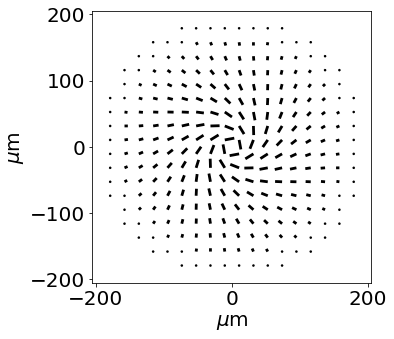

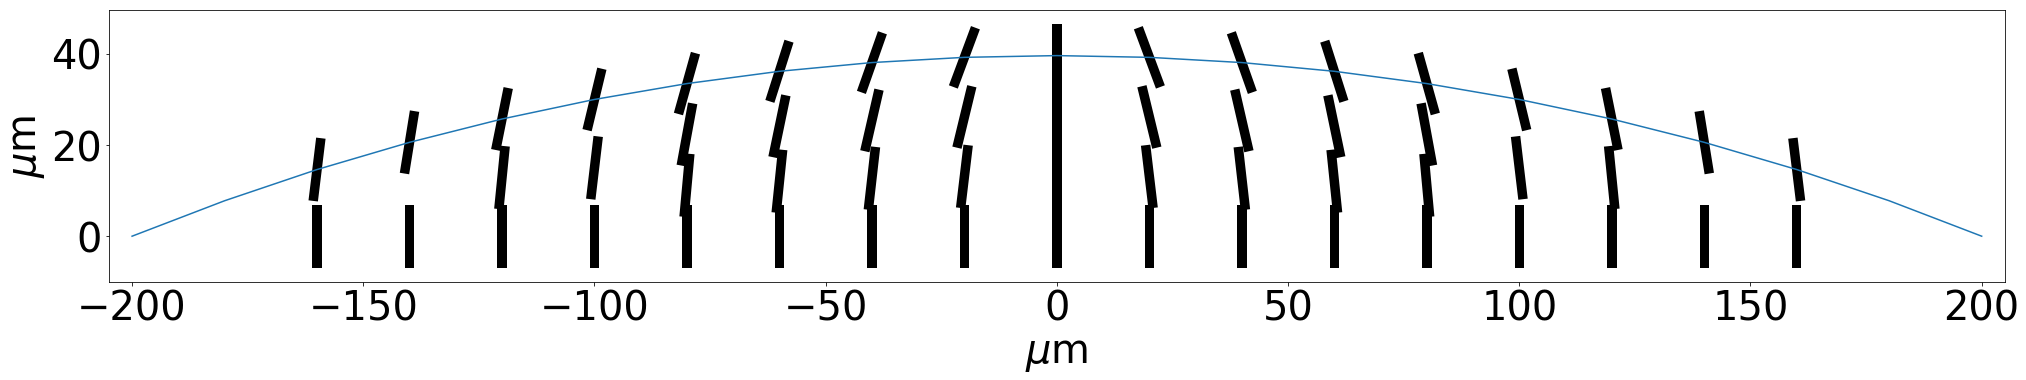

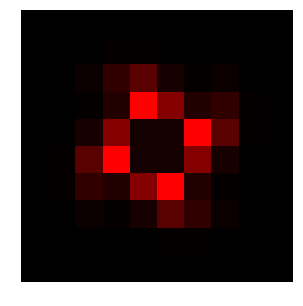

NameError: name 'imH' is not defined

In [3]:
RGBdrop(ContactAngle=22.4/180*pi,
        Diameter=400,
        ExtReff=1.6031, 
        OrdReff=1.4859,
        XYRes=10,
        ZRes=3,
        rcore_down=1e-10,
        theta_down=90/180*pi,
        rcore_up=3,
        theta_up=-65/180*pi,
        phi_0=pi/3,
        dense=21,
        ZNumDir=5,
        WithLam=False,
        DirrVisul=True,
        red=True,
        savename=None)#"I52_plan_red_2")
